<a href="https://colab.research.google.com/github/Hirwabrian/Group19-Machine_Learning_Techniques_I/blob/main/gru_19_collab_book.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 50.8 MB/s eta 0:00:00


#1: Imports and Setup

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import gensim
from gensim.models import Word2Vec, FastText
import gensim.downloader as api
import re
import string
import os
import argparse
import time
import matplotlib.pyplot as plt

#2: Preprocessing

In [ ]:

def preprocess_ag_news(file_path):
    # 1. Load data - skipping the header row
    df = pd.read_csv(file_path, header=0, names=['label', 'title', 'description'], engine='python')

    # 2. Map numeric labels to names for better visualization
    label_map = {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Sci/Tech'}
    df['class_name'] = df['label'].map(label_map)

    # 3. Combine Title and Description
    df['text'] = df['title'] + " " + df['description']

    def clean_text(text):
        # Lowercase
        text = text.lower()
        # Remove backslash escapes like \n or \b
        text = re.sub(r'\\[nb]', ' ', text)
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text

    print(f"Cleaning {file_path}...")
    df['text'] = df['text'].apply(clean_text)

    # Keep only what is necessary for the models
    return df[['text', 'label', 'class_name']]

# EXECUTION
train_cleaned = preprocess_ag_news('/content/train.csv')
test_cleaned = preprocess_ag_news('/content/test.csv')

# Save to shared CSVs
train_cleaned.to_csv('ag_news_train_cleaned.csv', index=False)
test_cleaned.to_csv('ag_news_test_cleaned.csv', index=False)

print("\nSample Output:")
print(train_cleaned.head())
print("\nClass Distribution:")
print(train_cleaned['class_name'].value_counts())

Cleaning /content/train.csv...
Cleaning /content/test.csv...

Sample Output:
                                                text  label class_name
0  wall st bears claw back into the black reuters...      3   Business
1  carlyle looks toward commercial aerospace reut...      3   Business
2  oil and economy cloud stocks outlook reuters r...      3   Business
3  iraq halts oil exports from main southern pipe...      3   Business
4  oil prices soar to alltime record posing new m...      3   Business

Class Distribution:
class_name
Business    30000
Sci/Tech    30000
Sports      30000
World       30000
Name: count, dtype: int64


#3: Dataset Class

In [ ]:
class AGNewsDataset(Dataset):
    def __init__(self, texts, labels, vectorizer_func=None):
        self.texts = texts
        self.labels = labels
        self.vectorizer_func = vectorizer_func

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        if self.vectorizer_func:
            vector = self.vectorizer_func(text)
            return torch.tensor(vector, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

        return text, label

#4: GRU Classifier Model

In [ ]:
class GRUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout, embedding_matrix=None, freeze_embeddings=True, use_embedding_layer=True):
        super(GRUClassifier, self).__init__()

        self.use_embedding_layer = use_embedding_layer

        if use_embedding_layer:
            # For Word2Vec, FastText, GloVe
            num_embeddings, embedding_dim = embedding_matrix.shape
            self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=freeze_embeddings)
            # Bidirectional GRU
            self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout, bidirectional=True)
        else:
            # For TF-IDF (Direct input)
            # Input shape: [Batch, Sequence_Length, Features] -> Here Sequence_Length is 1
            # Bidirectional GRU
            self.gru = nn.GRU(input_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout, bidirectional=True)

        # Hidden dim is doubled for bidirectional
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape: [Batch, Seq_Len] for Embedding strategies
        # x shape: [Batch, 1, Features] for TF-IDF

        if self.use_embedding_layer:
            embedded = self.embedding(x) # [Batch, Seq_Len, Emb_Dim]
            out, hidden = self.gru(embedded)
        else:
            # TF-IDF passed directly
            out, hidden = self.gru(x)

        # hidden shape: [Num_Layers * Num_Directions, Batch, Hidden_Dim]
        # Concatenate the last forward and backward hidden states
        # hidden[-2,:,:] is last forward, hidden[-1,:,:] is last backward
        if self.gru.bidirectional:
             hidden_cat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
             hidden_cat = hidden[-1,:,:]

        hidden_cat = self.dropout(hidden_cat)
        return self.fc(hidden_cat)

#5: Training and Evaluation Functions

In [ ]:
def train_model(model, train_loader, criterion, optimizer, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        start_time = time.time()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(train_loader):.4f} | Acc: {correct/total:.4f} | Time: {time.time()-start_time:.1f}s")

    return model

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

#6: plot

In [ ]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return total_loss / len(test_loader), correct / total

def train_and_plot(model, train_loader, test_loader, criterion, optimizer, device, epochs, model_name):
    print(f"\nTraining {model_name}...")

    history = {
        'train_loss': [], 'train_acc': [],
        'test_loss': [], 'test_acc': []
    }

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        start_time = time.time()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total

        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} Acc: {test_acc:.4f} | Time: {time.time()-start_time:.1f}s")

        # Log to file
        with open("experiment_results_with_plots.txt", "a") as f:
            timestamp = time.strftime("%Y-%m-%d %H:%M:%S")
            f.write(f"[{timestamp}] {model_name} Epoch {epoch+1}: Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f}\n")

    # Plotting
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_loss'], label='Train Loss')
    plt.plot(epochs_range, history['test_loss'], label='Test Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_acc'], label='Train Acc')
    plt.plot(epochs_range, history['test_acc'], label='Test Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plot_filename = f"{model_name.lower().replace(' ', '_')}_plot.png"
    plt.savefig(plot_filename)
    print(f"Plot saved to {plot_filename}")
    plt.close()

#7: Sequence Embedding Helpers

In [ ]:

def run_tfidf_pipeline(train_texts, train_labels, test_texts, test_labels, device, epochs):
    print("\n--- TF-IDF Pipeline ---")
    vectorizer = TfidfVectorizer(max_features=2000)
    X_train = vectorizer.fit_transform(train_texts).toarray()
    X_test = vectorizer.transform(test_texts).toarray()

    class TFIDFDataset(Dataset):
        def __init__(self, vectors, labels):
            self.vectors = torch.FloatTensor(vectors).unsqueeze(1)
            self.labels = torch.LongTensor(labels.values)
        def __len__(self): return len(self.labels)
        def __getitem__(self, idx): return self.vectors[idx], self.labels[idx]

    train_loader = DataLoader(TFIDFDataset(X_train, train_labels), batch_size=64, shuffle=True)
    test_loader = DataLoader(TFIDFDataset(X_test, test_labels), batch_size=64)

    model = GRUClassifier(input_dim=2000, hidden_dim=256, output_dim=4, n_layers=2, dropout=0.5, use_embedding_layer=False)
    model.to(device)

    train_and_plot(model, train_loader, test_loader, nn.CrossEntropyLoss(), optim.Adam(model.parameters(), lr=0.001), device, epochs, "TF-IDF")

# --- Helper for Sequence Embeddings ---
def tokenize_corpus(texts):
    return [text.split() for text in texts]

def build_vocab_and_indexer(tokenized_texts, min_freq=1):
    word2idx = {'<PAD>': 0, '<UNK>': 1}
    idx2word = {0: '<PAD>', 1: '<UNK>'}
    word_counts = {}
    for text in tokenized_texts:
        for word in text:
            word_counts[word] = word_counts.get(word, 0) + 1
    idx = 2
    for word, count in word_counts.items():
        if count >= min_freq:
            word2idx[word] = idx
            idx2word[idx] = word
            idx += 1
    return word2idx, idx2word

def encode_texts(tokenized_texts, word2idx, max_len=150):
    encoded_features = []
    for text in tokenized_texts:
        encoded = [word2idx.get(word, word2idx['<UNK>']) for word in text]
        if len(encoded) < max_len:
            encoded += [word2idx['<PAD>']] * (max_len - len(encoded))
        else:
            encoded = encoded[:max_len]
        encoded_features.append(encoded)
    return np.array(encoded_features)

def create_embedding_matrix(word2idx, gensim_model, embedding_dim):
    vocab_size = len(word2idx)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in word2idx.items():
        if word in gensim_model.wv:
            embedding_matrix[idx] = gensim_model.wv[word]
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim, ))
    return embedding_matrix

class SequenceDataset(Dataset):
    def __init__(self, encoded_texts, labels):
        self.texts = torch.LongTensor(encoded_texts)
        self.labels = torch.LongTensor(labels.values)
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx): return self.texts[idx], self.labels[idx]

def run_embedding_pipeline(embedding_type, train_texts, train_labels, test_texts, test_labels, device, epochs):
    print(f"\n--- {embedding_type} Pipeline ---")

    train_tokens = tokenize_corpus(train_texts)
    test_tokens = tokenize_corpus(test_texts)

    embedding_dim = 100
    model_w2v = None

    if embedding_type == 'Skip-gram':
        model_w2v = Word2Vec(sentences=train_tokens, vector_size=embedding_dim, window=5, min_count=2, sg=1, workers=4)
    elif embedding_type == 'FastText':
        model_w2v = FastText(sentences=train_tokens, vector_size=embedding_dim, window=5, min_count=2, workers=4)
    elif embedding_type == 'GloVe':
        try:
            print("Downloading/Loading GloVe model (glove-twitter-25)...")
            glove_vectors = api.load("glove-twitter-25")
            embedding_dim = 25
        except Exception as e:
            print(f"Failed to load GloVe: {e}. Skipping GloVe.")
            return

    word2idx, _ = build_vocab_and_indexer(train_tokens, min_freq=2)

    if embedding_type == 'GloVe':
         vocab_size = len(word2idx)
         embedding_matrix = np.zeros((vocab_size, 25))
         for word, idx in word2idx.items():
            if word in glove_vectors:
                embedding_matrix[idx] = glove_vectors[word]
            else:
                embedding_matrix[idx] = np.random.normal(scale=0.6, size=(25,))
    else:
        embedding_matrix = create_embedding_matrix(word2idx, model_w2v, embedding_dim)

    X_train = encode_texts(train_tokens, word2idx, max_len=150)
    X_test = encode_texts(test_tokens, word2idx, max_len=150)

    train_loader = DataLoader(SequenceDataset(X_train, train_labels), batch_size=64, shuffle=True)
    test_loader = DataLoader(SequenceDataset(X_test, test_labels), batch_size=64)

    model = GRUClassifier(input_dim=None, hidden_dim=256, output_dim=4, n_layers=2, dropout=0.5,
                          embedding_matrix=embedding_matrix, freeze_embeddings=True, use_embedding_layer=True)
    model.to(device)

    train_and_plot(model, train_loader, test_loader, nn.CrossEntropyLoss(), optim.Adam(model.parameters(), lr=0.001), device, epochs, embedding_type)


#6: TF-IDF Pipeline

In [ ]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--debug', action='store_true', help='Run on small subset')
    parser.add_argument('--sample_size', type=int)
    parser.add_argument('--epochs', type=int)
    parser.add_argument('--train_file', type=str, default='train.csv')
    parser.add_argument('--test_file', type=str, default='test.csv')
    args = parser.parse_args(args=[]) # Modified to ignore system arguments

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    sample_size = args.sample_size if args.sample_size else (200 if args.debug else None)
    epochs = args.epochs if args.epochs else (1 if args.debug else 5)

    print(f"Device: {device} | Sample Size: {sample_size} | Epochs: {epochs}")

    train_df = preprocess_ag_news(args.train_file)
    test_df = preprocess_ag_news(args.test_file)

    if train_df.empty or test_df.empty: exit()

    # Convert labels to 0-indexed
    train_df['label_idx'] = train_df['label'] - 1
    test_df['label_idx'] = test_df['label'] - 1

    train_texts, train_labels = train_df['text'].values, train_df['label_idx']
    test_texts, test_labels = test_df['text'].values, test_df['label_idx']

    run_tfidf_pipeline(train_texts, train_labels, test_texts, test_labels, device, epochs)


Device: cuda | Sample Size: None | Epochs: 5
Cleaning train.csv...
Cleaning test.csv...

--- TF-IDF Pipeline ---

Training TF-IDF...
Epoch 1/5 | Train Loss: 0.3709 Acc: 0.8703 | Test Loss: 0.3252 Acc: 0.8861 | Time: 10.7s
Epoch 2/5 | Train Loss: 0.3032 Acc: 0.8920 | Test Loss: 0.3202 Acc: 0.8901 | Time: 10.6s
Epoch 3/5 | Train Loss: 0.2862 Acc: 0.8965 | Test Loss: 0.3162 Acc: 0.8895 | Time: 12.6s
Epoch 4/5 | Train Loss: 0.2725 Acc: 0.9005 | Test Loss: 0.3152 Acc: 0.8918 | Time: 11.0s
Epoch 5/5 | Train Loss: 0.2595 Acc: 0.9047 | Test Loss: 0.3198 Acc: 0.8932 | Time: 12.0s
Plot saved to tf-idf_plot.png


#plot for tf-idf loss and accuacy

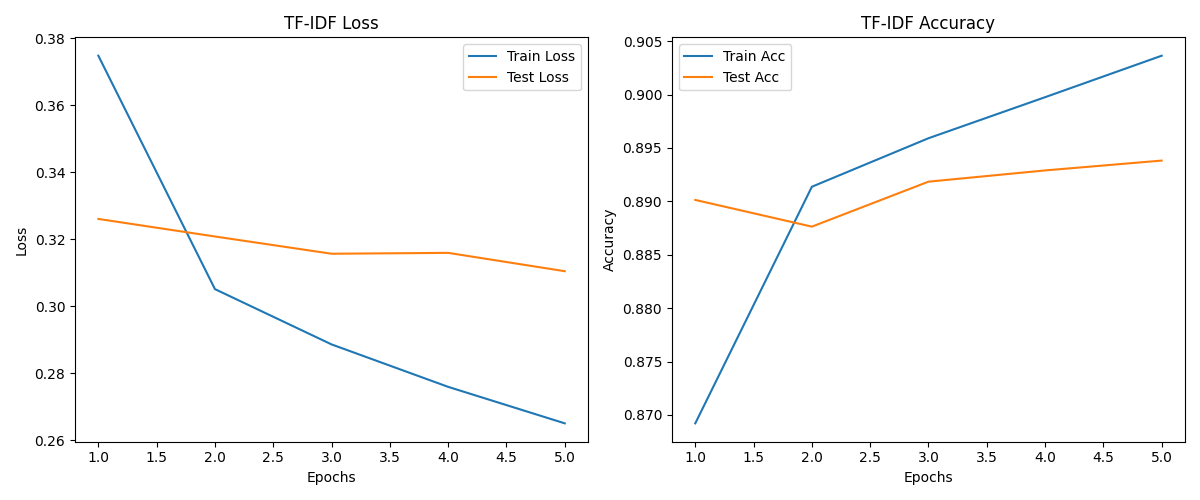

In [ ]:
from IPython.display import Image
Image(filename='tf-idf_plot.png')

Embedding Pipelines Skip-gram

In [ ]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--debug', action='store_true', help='Run on small subset')
    parser.add_argument('--sample_size', type=int)
    parser.add_argument('--epochs', type=int)
    parser.add_argument('--train_file', type=str, default='train.csv')
    parser.add_argument('--test_file', type=str, default='test.csv')
    args = parser.parse_args(args=[]) # Modified to ignore system arguments

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    sample_size = args.sample_size if args.sample_size else (200 if args.debug else None)
    epochs = args.epochs if args.epochs else (1 if args.debug else 5)

    print(f"Device: {device} | Sample Size: {sample_size} | Epochs: {epochs}")

    train_df = preprocess_ag_news(args.train_file)
    test_df = preprocess_ag_news(args.test_file)

    if train_df.empty or test_df.empty: exit()

    # Convert labels to 0-indexed
    train_df['label_idx'] = train_df['label'] - 1
    test_df['label_idx'] = test_df['label'] - 1

    train_texts, train_labels = train_df['text'].values, train_df['label_idx']
    test_texts, test_labels = test_df['text'].values, test_df['label_idx']
    run_embedding_pipeline('Skip-gram', train_texts, train_labels, test_texts, test_labels, device, epochs)

Device: cpu | Sample Size: None | Epochs: 5
Cleaning train.csv...
Cleaning test.csv...

--- Skip-gram Pipeline ---

Training Skip-gram...
Epoch 1/5 | Train Loss: 0.3203 Acc: 0.8915 | Test Loss: 0.2701 Acc: 0.9049 | Time: 4639.0s
Epoch 2/5 | Train Loss: 0.2629 Acc: 0.9098 | Test Loss: 0.2512 Acc: 0.9117 | Time: 10745.0s
Epoch 3/5 | Train Loss: 0.2387 Acc: 0.9176 | Test Loss: 0.2298 Acc: 0.9204 | Time: 4294.9s
Epoch 4/5 | Train Loss: 0.2180 Acc: 0.9235 | Test Loss: 0.2413 Acc: 0.9204 | Time: 4254.3s
Epoch 5/5 | Train Loss: 0.2024 Acc: 0.9299 | Test Loss: 0.2324 Acc: 0.9155 | Time: 4422.4s
Plot saved to skip-gram_plot.png


#skip gram final result




In [ ]:
def get_final_test_accuracy(log_file='experiment_results_with_plots.txt'):
    final_accuracies = {}
    with open(log_file, 'r') as f:
        lines = f.readlines()

    tf_idf_accuracies = []
    skip_gram_accuracies = []

    for line in lines:
        if 'TF-IDF Epoch' in line:

            match = re.search(r'Test Acc=([0-9.]+)', line)
            if match: tf_idf_accuracies.append(float(match.group(1)))
        elif 'Skip-gram Epoch' in line:

            match = re.search(r'Test Acc=([0-9.]+)', line)
            if match: skip_gram_accuracies.append(float(match.group(1)))

    if tf_idf_accuracies: final_accuracies['TF-IDF'] = tf_idf_accuracies[-1]
    if skip_gram_accuracies: final_accuracies['Skip-gram'] = skip_gram_accuracies[-1]

    return final_accuracies

final_test_accs = get_final_test_accuracy()

print("Final Test Accuracies:")
for model_name, accuracy in final_test_accs.items():
    print(f"  {model_name}: {accuracy:.4f}")

Final Test Accuracies:
  Skip-gram: 0.9155


#skip gram plot for loss and Accuracy

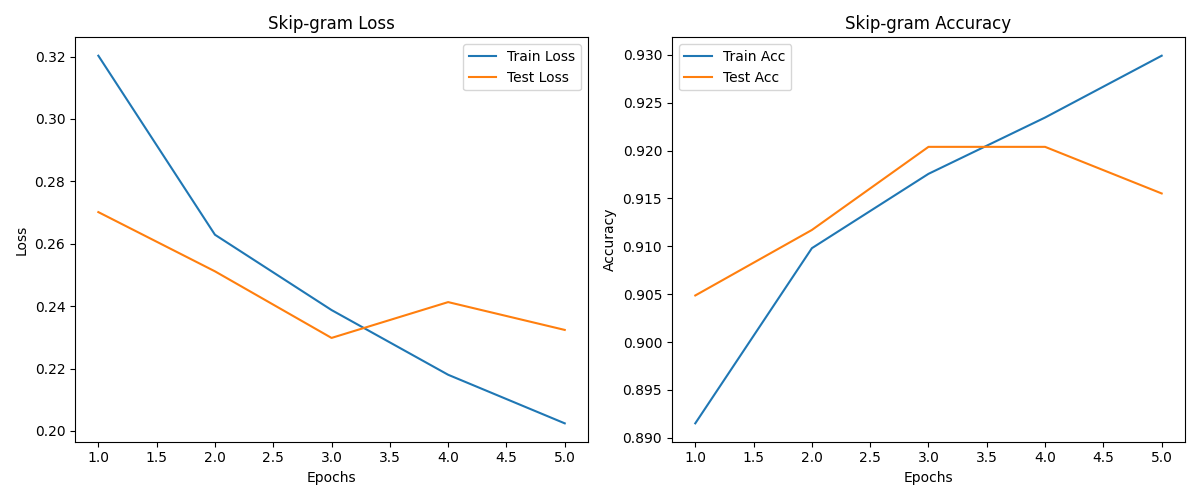

In [ ]:
from IPython.display import Image
Image(filename='skip-gram_plot.png')

#Embedding Pipelines Skip-gram

In [ ]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--debug', action='store_true', help='Run on small subset')
    parser.add_argument('--sample_size', type=int)
    parser.add_argument('--epochs', type=int)
    parser.add_argument('--train_file', type=str, default='train.csv')
    parser.add_argument('--test_file', type=str, default='test.csv')
    args = parser.parse_args(args=[]) # Modified to ignore system arguments

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    sample_size = args.sample_size if args.sample_size else (200 if args.debug else None)
    epochs = args.epochs if args.epochs else (1 if args.debug else 5)

    print(f"Device: {device} | Sample Size: {sample_size} | Epochs: {epochs}")

    train_df = preprocess_ag_news(args.train_file)
    test_df = preprocess_ag_news(args.test_file)

    if train_df.empty or test_df.empty: exit()

    # Convert labels to 0-indexed
    train_df['label_idx'] = train_df['label'] - 1
    test_df['label_idx'] = test_df['label'] - 1

    train_texts, train_labels = train_df['text'].values, train_df['label_idx']
    test_texts, test_labels = test_df['text'].values, test_df['label_idx']
    run_embedding_pipeline('FastText', train_texts, train_labels, test_texts, test_labels, device, epochs)


Device: cuda | Sample Size: None | Epochs: 5
Cleaning train.csv...
Cleaning test.csv...

--- FastText Pipeline ---

Training FastText...
Epoch 1/5 | Train Loss: 0.3460 Acc: 0.8803 | Test Loss: 0.2871 Acc: 0.9028 | Time: 79.9s
Epoch 2/5 | Train Loss: 0.2776 Acc: 0.9027 | Test Loss: 0.2682 Acc: 0.9063 | Time: 83.3s
Epoch 3/5 | Train Loss: 0.2484 Acc: 0.9135 | Test Loss: 0.2563 Acc: 0.9138 | Time: 86.2s
Epoch 4/5 | Train Loss: 0.2263 Acc: 0.9215 | Test Loss: 0.2671 Acc: 0.9093 | Time: 87.3s
Epoch 5/5 | Train Loss: 0.2127 Acc: 0.9270 | Test Loss: 0.2575 Acc: 0.9100 | Time: 87.1s
Plot saved to fasttext_plot.png


#fasttext plot for loss and Accuracy

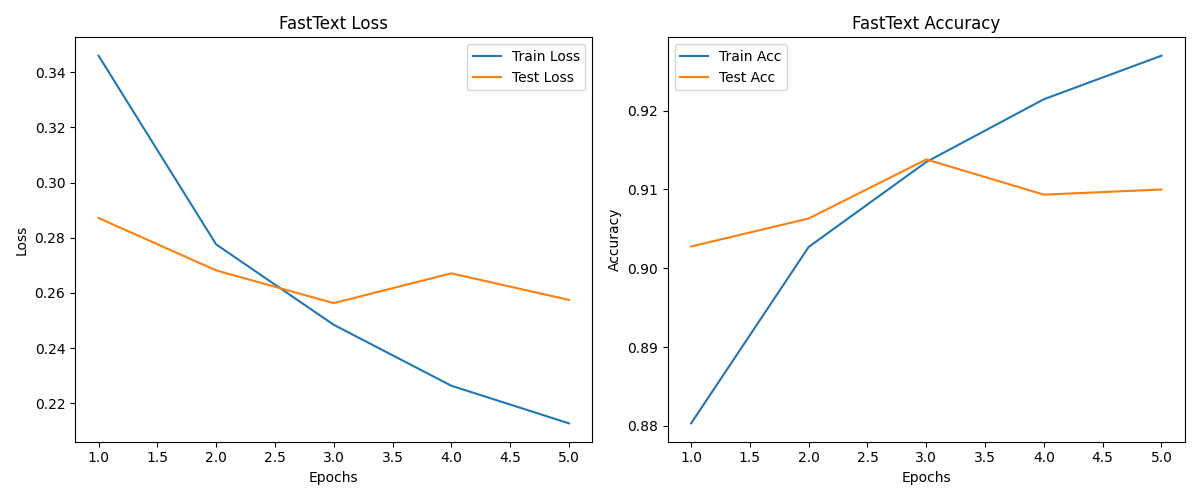

In [ ]:
from IPython.display import Image
Image(filename='fasttext_plot.png')

#Embedding Pipelines glove

In [ ]:
   run_embedding_pipeline('GloVe', train_texts, train_labels, test_texts, test_labels, device, epochs)



--- GloVe Pipeline ---
Downloading/Loading GloVe model (glove-twitter-25)...
[==================================================] 100.0% 104.8/104.8MB downloaded

Training GloVe...
Epoch 1/5 | Train Loss: 0.4320 Acc: 0.8441 | Test Loss: 0.3594 Acc: 0.8743 | Time: 79.9s
Epoch 2/5 | Train Loss: 0.3366 Acc: 0.8828 | Test Loss: 0.3118 Acc: 0.8912 | Time: 82.6s
Epoch 3/5 | Train Loss: 0.2985 Acc: 0.8960 | Test Loss: 0.2932 Acc: 0.8999 | Time: 84.5s
Epoch 4/5 | Train Loss: 0.2673 Acc: 0.9074 | Test Loss: 0.2862 Acc: 0.9024 | Time: 83.5s
Epoch 5/5 | Train Loss: 0.2408 Acc: 0.9164 | Test Loss: 0.2849 Acc: 0.9005 | Time: 83.8s
Plot saved to glove_plot.png


#Glove plot for the loss and Accuracy

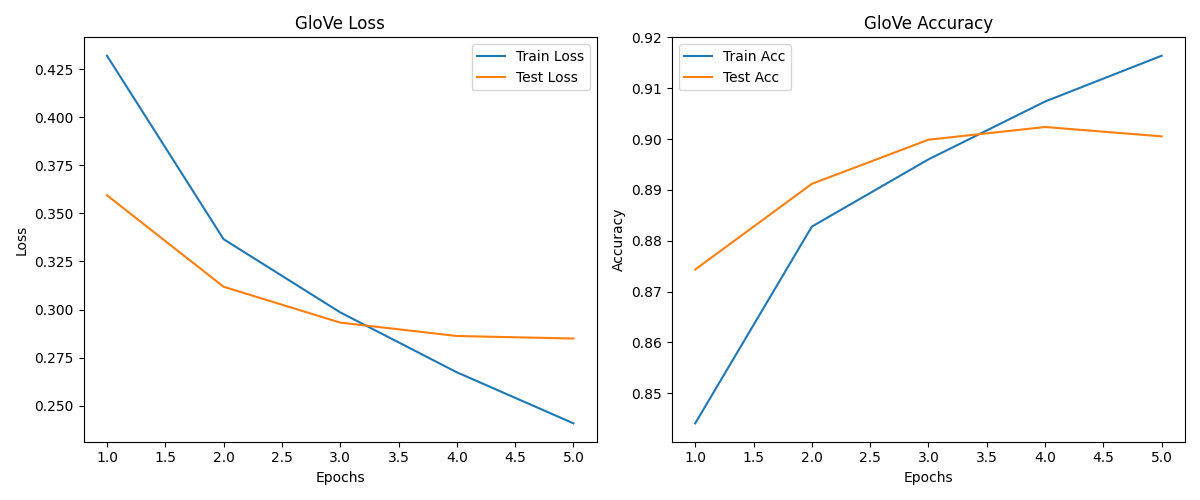

In [ ]:
from IPython.display import Image
Image(filename='glove_plot.png')

#final result for the model accuracies

In [ ]:
def get_final_test_accuracy(log_file='experiment_results_with_plots.txt'):
    final_accuracies = {}
    with open(log_file, 'r') as f:
        lines = f.readlines()

    tf_idf_accuracies = []
    skip_gram_accuracies = []
    fasttext_accuracies = []
    glove_accuracies = []

    for line in lines:
        if 'TF-IDF Epoch' in line:
            match = re.search(r'Test Acc=([0-9.]+)', line)
            if match: tf_idf_accuracies.append(float(match.group(1)))
        elif 'Skip-gram Epoch' in line:
            match = re.search(r'Test Acc=([0-9.]+)', line)
            if match: skip_gram_accuracies.append(float(match.group(1)))
        elif 'FastText Epoch' in line:
            match = re.search(r'Test Acc=([0-9.]+)', line)
            if match: fasttext_accuracies.append(float(match.group(1)))
        elif 'GloVe Epoch' in line:
            match = re.search(r'Test Acc=([0-9.]+)', line)
            if match: glove_accuracies.append(float(match.group(1)))

    if tf_idf_accuracies: final_accuracies['TF-IDF'] = tf_idf_accuracies[-1]
    if skip_gram_accuracies: final_accuracies['Skip-gram'] = skip_gram_accuracies[-1]
    if fasttext_accuracies: final_accuracies['FastText'] = fasttext_accuracies[-1]
    if glove_accuracies: final_accuracies['GloVe'] = glove_accuracies[-1]

    return final_accuracies

final_test_accs = get_final_test_accuracy()

print("Final Test Accuracies:")
for model_name, accuracy in final_test_accs.items():
    print(f"  {model_name}: {accuracy:.4f}")

Final Test Accuracies:
  TF-IDF: 0.8932
  FastText: 0.9100
  GloVe: 0.9005
